# Online Hate Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn import svm,metrics,neighbors,tree
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_csv("labelled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

# Columns Key - 
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).<br/>
hate_speech = number of CF users who judged the tweet to be hate speech.<br/>
offensive_language = number of CF users who judged the tweet to be offensive.<br/>
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.<br/>
class = class label for majority of CF users.<br/>
0 - hate speech<br/>
1 - offensive  language<br/>
2 - neither<br/>
tweet = raw tweet text<br/>

<AxesSubplot:>

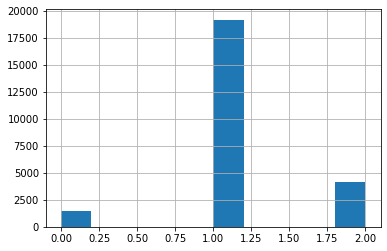

In [6]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [3]:
tweets=df.tweet

# Feature Generation

In [4]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()
def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    return parsed_text

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    #stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

1. 'preprocess function' - <br/>
Accepts a text string and replaces:<br/>
    1) urls with URLHERE<br/>
    2) lots of whitespace with one instance<br/>
    3) mentions with MENTIONHERE<br/>
    This allows us to get standardized counts of urls and mentions.<br/>
    Without caring about specific people mentioned.<br/><br/>
2. 'tokenize function' - <br/>
Removes punctuation & excess whitespace, sets to lowercase,<br/>
and stems tweets. Returns a list of stemmed tokens.<br/><br/>
3. 'basic_tokenize function' - <br/>
Same as tokenize but without the stemming.<br/><br/>



In [5]:
#Construction of tfidf matrix and obtaining the relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} 
#The keys are indices and values are IDF scores

In [6]:
#Obtaining the POS tags for tweets and saving them as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [7]:
#The tfidf vectorizer is used to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [8]:
#Construction of POS-TF matrix and obtaining the vocabulary dictionary
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [9]:
#Obtaining other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) # to get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    #Modified FK grade, where average words per sentence is just number of words / 1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    #Modified FRE score, where sentence is fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

1. 'count_twitter_objs function' - <br/>
Accepts a text string and replaces:<br/>
    1) urls with URLHERE<br/>
    2) lots of whitespace with one instance<br/>
    3) mentions with MENTIONHERE<br/>
    4) hashtags with HASHTAGHERE<br/>
    This allows us to get standardized counts of urls and mentions.<br/>
    Without caring about specific people mentioned.<br/>
    Returns counts of urls, mentions, and hashtags.<br/><br/>
2. 'other_features function' - <br/>
This function takes a string and returns a list of features.<br/>
These include Sentiment scores, Text and Readability scores,<br/>
as well as Twitter specific features.<br/><br/>
3. 'get_feature_array function' - <br/>
This function generates the features and returns them as an array.<br/><br/>

In [10]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [11]:
feats = get_feature_array(tweets)

In [12]:
#Gathering all the features
M = np.concatenate([tfidf,pos,feats],axis=1)

In [13]:
M.shape

(24783, 8197)

In [14]:
#Obtaining the list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names


In [15]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

# Model Training and Execution

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [22]:
y.value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

# Logistic Regression

In [18]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l2", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [19]:
param_grid = [{}]
grid_search = GridSearchCV(pipe,param_grid,cv=StratifiedKFold(n_splits=5, 
              random_state=42,shuffle = True).split(X_train, y_train),verbose=2)

In [20]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

[CV] END .................................................... total time=  35.6s


/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

[CV] END .................................................... total time=  31.6s


/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

[CV] END .................................................... total time=  35.0s


/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

[CV] END .................................................... total time=  34.6s


/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

[CV] END .................................................... total time=  34.3s


/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jaineet/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

In [21]:
y_preds = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,y_preds, normalize = True))
print(metrics.classification_report(y_test,y_preds))
print("\tConfusion Matrix")
print(metrics.confusion_matrix(y_test,y_preds))

Accuracy: 0.8305768455022187
              precision    recall  f1-score   support

           0       0.29      0.54      0.37       164
           1       0.95      0.84      0.89      1905
           2       0.75      0.89      0.81       410

    accuracy                           0.83      2479
   macro avg       0.66      0.76      0.69      2479
weighted avg       0.87      0.83      0.85      2479

	Confusion Matrix
[[  88   52   24]
 [ 201 1606   98]
 [  17   28  365]]


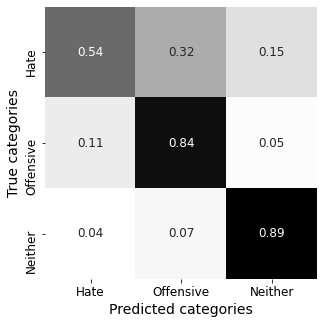

In [22]:
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# Decision Tree

In [39]:
clf = Pipeline([('clf', DecisionTreeClassifier(random_state=101))])  

criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11] 
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None] 

param_grid = [{ 'clf__class_weight': class_weight
                ,'clf__criterion': criterion
                ,'clf__splitter': splitter
                ,'clf__max_depth': max_depth
                ,'clf__min_samples_leaf': min_samples_leaf
            }]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1,n_jobs=12)

gs.fit(X_train,y_train)

pred = gs.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,pred, normalize = True))
print(metrics.classification_report(y_test,pred))
print("\tConfusion Matrix")
print(metrics.confusion_matrix(y_test,pred))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Accuracy: 0.8805970149253731
              precision    recall  f1-score   support

           0       0.45      0.17      0.25       164
           1       0.93      0.93      0.93      1905
           2       0.74      0.93      0.83       410

    accuracy                           0.88      2479
   macro avg       0.71      0.68      0.67      2479
weighted avg       0.87      0.88      0.87      2479

	Confusion Matrix
[[  28  103   33]
 [  32 1772  101]
 [   2   25  383]]


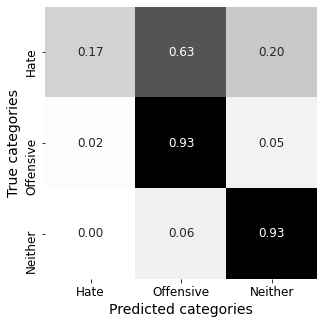

In [40]:
confusion_matrix = confusion_matrix(y_test,pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# ANN 

In [55]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([5.87256451, 0.43012246, 1.98099298])

In [56]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 5.872564507635598, 1: 0.43012245685083406, 2: 1.9809929833910649}

In [57]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [58]:
model = keras.Sequential([
    keras.layers.Dropout(0.5, input_shape=(8197,)),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3,activation = 'softmax')
                         ])

In [59]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['AUC'])

In [60]:
model.fit(X_train,y_train,epochs = 7,class_weight=class_weights)

Epoch 1/7
697/697 [==============================] - 2s 3ms/step - loss: 1.0407 - auc: 0.7367
Epoch 2/7
697/697 [==============================] - 2s 2ms/step - loss: 0.7419 - auc: 0.8502
Epoch 3/7
697/697 [==============================] - 2s 2ms/step - loss: 0.6523 - auc: 0.8722
Epoch 4/7
697/697 [==============================] - 2s 3ms/step - loss: 0.5883 - auc: 0.8941
Epoch 5/7
697/697 [==============================] - 2s 2ms/step - loss: 0.5406 - auc: 0.9036
Epoch 6/7
697/697 [==============================] - 2s 2ms/step - loss: 0.4981 - auc: 0.9189
Epoch 7/7
697/697 [==============================] - 2s 2ms/step - loss: 0.4672 - auc: 0.9258


In [61]:
loss,acc = model.evaluate(X_test,y_test,verbose= 1)
print(acc)

78/78 [==============================] - 0s 1ms/step - loss: 0.4576 - auc: 0.9439
0.9438818693161011


In [62]:
X = pd.DataFrame(M)
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [63]:
pred1 = np.argmax(model.predict(X_test), axis=-1)
print("Accuracy:",metrics.accuracy_score(y_test,pred1, normalize = True))
print(metrics.classification_report(y_test,pred1))
print("\tConfusion Matrix")
print(metrics.confusion_matrix(y_test,pred1))

Accuracy: 0.8390480032271077
              precision    recall  f1-score   support

           0       0.33      0.55      0.41       164
           1       0.95      0.86      0.90      1905
           2       0.73      0.86      0.79       410

    accuracy                           0.84      2479
   macro avg       0.67      0.76      0.70      2479
weighted avg       0.87      0.84      0.85      2479

	Confusion Matrix
[[  91   49   24]
 [ 165 1636  104]
 [  22   35  353]]


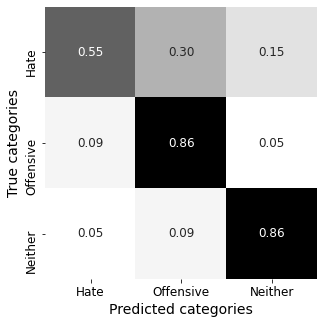

In [64]:
cm = metrics.confusion_matrix(y_test,pred1)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# SVM

In [46]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,pred, normalize = True))
print(metrics.classification_report(y_test,pred))
print("\tConfusion Matrix")
print(metrics.confusion_matrix(y_test,pred))

Accuracy: 0.8656716417910447
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       164
           1       0.87      0.98      0.92      1905
           2       0.81      0.70      0.75       410

    accuracy                           0.87      2479
   macro avg       0.90      0.56      0.56      2479
weighted avg       0.87      0.87      0.83      2479

	Confusion Matrix
[[   1  143   20]
 [   0 1860   45]
 [   0  125  285]]


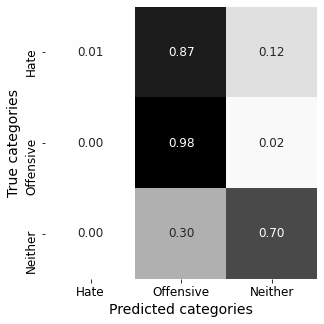

In [48]:
confusion_matrix = metrics.confusion_matrix(y_test,pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# KNN

In [49]:
clf = neighbors.KNeighborsClassifier()
para_grid = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,15,20],'weights':['uniform','distance']}
clf_g = GridSearchCV(clf,para_grid,cv=5)
clf_g.fit(X_train,y_train)
print(clf_g.best_params_)
pred = clf_g.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,pred, normalize = True))
print(metrics.classification_report(y_test,pred))
print("\tConfusion Matrix")
print(metrics.confusion_matrix(y_test,pred))

{'n_neighbors': 4, 'weights': 'distance'}
Accuracy: 0.7793465106897943
              precision    recall  f1-score   support

           0       0.37      0.06      0.10       164
           1       0.78      0.99      0.87      1905
           2       0.79      0.09      0.16       410

    accuracy                           0.78      2479
   macro avg       0.65      0.38      0.38      2479
weighted avg       0.76      0.78      0.71      2479

	Confusion Matrix
[[  10  151    3]
 [  13 1885    7]
 [   4  369   37]]


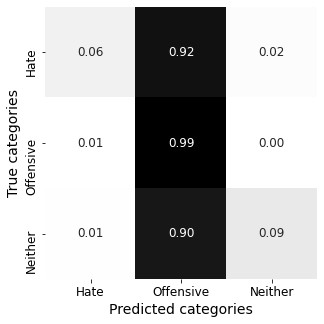

In [50]:
confusion_matrix = metrics.confusion_matrix(y_test,pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)